# Predicting Star Ratings of Edinburgh Airbnbs through Review Texts Analysis

# Notebook 5: Modelling_Review_Collapsed

***

# Table of Contents

***

## Import Libraries <a id='a1'></a>

In [1]:
# Main Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scipy Library for sparse  matrix
from scipy.sparse import csr_matrix

# NLP Libraries
import nltk
import re
import string
import html
import contractions
import langid
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from langid.langid import LanguageIdentifier

# Download from nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Feature Extraction Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Dummy Classifer 
from sklearn.dummy import DummyClassifier

# Modelling Libraries
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Evaluation Libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import joblib
import pickle as pk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12276\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Loading Relevant Data

In [2]:
# Load collapsed review data
df_collapsed_reviews_by_listing= joblib.load('data/df_collapsed_reviews_by_listing.pkl')

#### Ignore userwarnings

In [3]:
import warnings

# Ignore UserWarning
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

***

In [4]:
def customized_tokenizer(sentence):
    
    # Remove HTML tags and entities
    sentence = html.unescape(sentence)
    sentence = re.sub(r'<[^>]+>', '', sentence)
    
    # Remove HTML white spaces \r<br/> and <br/>
    sentence = re.sub(r'(\r<br/>)|(<br/>)', ' ', sentence)
    
    # Remove punctuations
    sentence = re.sub(r'[^\w\s]', '', sentence)
    
    # Lowercase text
    sentence = sentence.lower()
    
    # Remove whitespaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Remove emails
    sentence = re.sub(r'\S*@\S*\s?', '', sentence)
    
    # Remove emojis
    sentence = sentence.encode('ascii', 'ignore').decode('ascii')
    
    # Remove special characters
    sentence = re.sub(r'[^A-Za-z\s]', '', sentence)
    
    # Remove numbers
    sentence = re.sub(r'[0-9]+', '', sentence)
    
    # Remove weblinks
    sentence = re.sub(r'http\S+', '', sentence)
    
    # Expand contractions
    sentence = contractions.fix(sentence)
    
    # Remove non-English text characters
    if langid.classify(sentence)[0] != 'en':
        sentence = ''
    
    # Remove English stopwords
    eng_stop_words=stopwords.words('english')
    # Append EDA insights driven stop words
    eng_stop_words.extend(['apartment','flat','edinburgh','could', 'would', 'x', 'caroline', 'stay']) 
    stop_words = set(eng_stop_words)
    tokens = sentence.split()
    sentence = ' '.join([word for word in tokens if word.lower() not in stop_words])
    
    # Perform text stemming
    lemmatizer = WordNetLemmatizer()
    sentence = ' '.join([lemmatizer.lemmatize(word, pos = 'v') for word in sentence.split()])
    
    # Tokenize cleaned sentence
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    
    return tokens

***

#### Check the uncollapsed review data shape

In [5]:
print(f'The dataset contains all reviews listed individually is of dimension {df_collapsed_reviews_by_listing.shape}')

The dataset contains all reviews listed individually is of dimension (5908, 45)


# Modelling Set up <a id='a3'></a>

## Split the variables <a id='a3.1'></a>

We need to split the variables into dependent and independent variables before we start fitting the model. The target variable will be the sentiment scores. We will focus on the overall sentiment score and attempt to further analyse the reviews with the other sub-rating transformed sentiment scores.

In [7]:
# Define X and y for the future model
X = df_collapsed_reviews_by_listing.drop(['Overall_sentiment',
                                          'accuracy_sentiment',
                                          'cleanliness_sentiment',
                                          'checkin_sentiment',
                                          'communication_sentiment',
                                          'location_sentiment',
                                          'value_sentiment'], axis=1)
y = df_collapsed_reviews_by_listing['Overall_sentiment']

In [8]:
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (5908, 38)
y Shape: (5908,)


In [9]:
X.head(1).T

,0
host_response_rate,100.0
host_acceptance_rate,92.0
host_is_superhost,1
latitude,55.95759
longitude,-3.18805
accommodates,2
bathroom_num,1.0
beds,1.0
minimum_nights,3
maximum_nights,30


In [10]:
y.unique()

array([1, 0], dtype=int64)

The dependent variable stored as **X** contains all cleaned listing related numerical data as well as a column that contains the guest review data.

The independent variable stored as **y** contains the **Overall sentiment score** that was transformed from the listing's average overall rating score:
- 1 was denoted by Overall rating score > 4.8
- 0 was denoted by Overall rating score < 4.8

***

## Target Variable Distribution <a id='a3.2'></a>

In the EDA notebook, we analyzed the distribution of overall sentiments in the listing data and showed that the scores are balanced (**1: 58%, 0: 42%**). Now that we've merged all reviews with their corresponding listings and attached sentiment scores, it's important to recheck the distribution to ensure that the sentiment scores remain balanced after the data merging process.

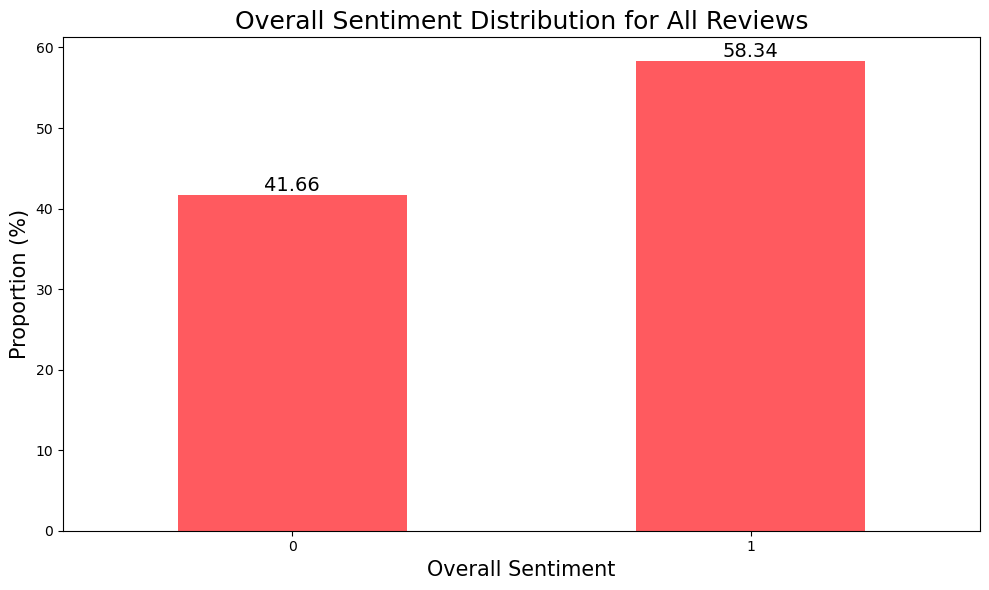

In [11]:
# Create distribution results for our target variable
overall_sentiment_distribution=round(df_collapsed_reviews_by_listing['Overall_sentiment'].value_counts(normalize=True).sort_index()*100, 2)

# Determine figure size
plt.figure(figsize=(10,6))

# Create barplot
ax = overall_sentiment_distribution.plot.bar(color='#FF5A5F')

# Add labels
plt.title('Overall Sentiment Distribution for All Reviews', fontsize=18)
plt.xlabel('Overall Sentiment', fontsize=15)
plt.ylabel('Proportion (%)', fontsize=15)
plt.bar_label(ax.containers[0], size=14)
plt.xticks(rotation = 360)

plt.tight_layout()  

# plt.savefig('Overall_Sentiment_Distribution.jpg', dpi =300)
plt.show()

***

## Train Test Split <a id='a3.4'></a>

The modelling process starts by splitting our dataset into training and testing sets. This procedure is fundamental for the effective evaluation of our model performance.

The training data is implemented upon which our model is built and refined, and the testing data provides the benchmark for assessing the model's predictive performance on unseen data. This ensures us to mitigate the risk of **overfitting**, as our model will not just memorize the data pattern but rather learns to generalize on new, unseen data.

Additionally, it is important that this splitting process must precede any data transformation steps including random sampling, text vectorization and scaling to prevent potential **data leakage**.

In [14]:
# Split test data as 30% of all data, determine random state to make sure every split is the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Show the number of rows for training and testing dataset
print(f'The number of rows obtained in the training data is {X_train.shape[0]}, with {X_train.shape[1]} feature columns.')
print(f'The number of rows obtained in the testing data is {X_test.shape[0]}, with {X_train.shape[1]} feature columns.')

The number of rows obtained in the training data is 4726, with 38 feature columns.
The number of rows obtained in the testing data is 1182, with 38 feature columns.


***

## Helper Function <a id='a3.5'></a>

Our dataset includes multiple non-review features, in the later text vectorization stage, it is not necessary for these columns to be processed by the vectorizers. Hence, we require a helper function to handle these numerical columns separately, and generate a column transformer based on our selection on different text vectorizers including `CountVectorizer` and `TfidfVectorizer`. 

Additionally, the numerical features in our dataset vary across different ranges, necessitating the scaling of data during the modeling stage. However, the text vectorizers will return a sparse matrix after transformation, while scalers like `StandardScaler` and `MinMaxScaler` require a dense array as input. Hence, we'll also need a function to convert the sparse matrix into a dense array.

This code is borrowed from [Allistair Cota](https://github.com/allistaircota/rate_my_restaurant/blob/main/notebooks/NB3-Modelling.ipynb).

Sources:

| Vectorizer  | Scaler| 
|:-------:|:--------:|
|[TF-IDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) |  [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)  |
|[Count-Vectorizer](https://en.wikipedia.org/wiki/Bag-of-words_model)  |[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) |

In [15]:
# Extract numerical column names
numeric_columns = X.select_dtypes(exclude='object').columns.to_list()

def define_col_trans(input_text, vectorizer):
    '''
    Returns a ColumnTransformer which first performs a 
    passthrough on the numeric columns, then applies
    a vectorizer on the `text` column
    
    PARAMETERS:
    - input_text: str, to name the vectorizer tuple
    - vectorizer: Sklearn text vectorizer
    
    RETURNS:
    - col_trans: sklearn ColumnTransformer
    
    '''
    
    col_trans = ColumnTransformer([
        ('numeric', 'passthrough', numeric_columns), # numerical_columns defined above
        (input_text, vectorizer, 'comments') # 'comments' as review text feature column
    ])
    
    return col_trans

def convert_to_array(sparse_matrix):
    '''
    Converts sparse matrix to dense array
    
    PARAMETERS:
    - sparse_matrix: scipy.sparse.csr_matrix or numpy array
    
    RETURNS:
    - If sparse_matrix is not a scipy.sparse.csr_matrix,
      sparse_matrix is returned. Else, returns the dense array
      form of sparse_matrix.
    
    '''
    
    if type(sparse_matrix) == csr_matrix:
    
        return sparse_matrix.toarray()
    
    else:
        return sparse_matrix

#### Text vectorizer list

In [16]:
# Define column transformers
ct_bow = define_col_trans('ct_bow',  CountVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer))
ct_tfidf = define_col_trans('ct_tfidf',  TfidfVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer))

***

# Baseline Model <a id='a4'></a>

As we are developing the best performed models for predicting the class of guest sentiments, it is crucial to establish a baseline model for comparison. We will utilise a **Dummy Classifier** model, which makes predictions without accessing dataset features, essentially performing random guessing. By establishing this baseline, we can decide that any model performing worse than the baseline model will not proceed to further analysis.

**Run Time**: 3mins 30s

In [ ]:
%%time

# Vectorize data using Bag of Words Vectorizer
bow_vec = CountVectorizer(max_features = 500, # Only obtain top 500 features based on vectorizer results
                            min_df=5, # Feature occurency should be bigger than 5 in the corpus
                            tokenizer=customized_tokenizer)

# Fit and transform on the vectorizer to training data
X_train_tfidf_d = bow_vec.fit_transform(X_train['comments']).toarray()

# Transform on both training data and testing data
X_test_tfidf_d = bow_vec.transform(X_test['comments']).toarray()

# Reset Index before concatenating
X_train_reset_index = X_train.reset_index(drop=True)
X_test_reset_index = X_test.reset_index(drop=True)

# Merge the resulting arrays with the original numeric features
X_train_tfidf_d_transformed = pd.concat([X_train_reset_index.drop(['comments'], axis=1),
                                         pd.DataFrame(X_train_tfidf_d, columns=[i for i in bow_vec.get_feature_names_out()])], axis=1)

X_test_tfidf_d_transformed = pd.concat([X_test_reset_index.drop(['comments'], axis=1), 
                                        pd.DataFrame(X_test_tfidf_d, columns=[i for i in bow_vec.get_feature_names_out()])], axis = 1)

# Print shape of the vectorized training feature data
print(f'X_train_transfomed_dummy : {X_train_tfidf_d_transformed.shape}')

In [ ]:
# # Dummy Classifier - Baseline Model
# Instantiate Dummy Classifier
dummy_classifier = DummyClassifier()

# Fit the Dummy Classifier on Training data
dummy_classifier.fit(X_train_tfidf_d_transformed, y_train_sample)

# Predict the fitted model on Testing Data
y_predict_d = dummy_classifier.predict(X_test_tfidf_d_transformed)

# Print F1 score
print(f'The Accuracy Score (%) for the Baseline Model is: {round(accuracy_score(y_test, y_predict_d)*100, 2)} %')

#### Classification report <a id='a4.1'></a>

In [ ]:
# Generate classification report to see specific classification evaluation metrics scores
baseline_report = classification_report(y_test, y_predict_d)
print(baseline_report)

Based on the findings from the classification report, the model classification accuracy score achieved by the dummy classifier is **37.42%**. This baseline performance indicates that future models should aim to surpass this threshold to be considered effective. Therefore, our goal for future models is to achieve an accuracy score higher than 38%, indicating improved predictive capability and accuracy in classifying sentiments. 

**Note**: This result is reflected by the actual proportion of negative sentiments in the testing dataset as Dummy Classifier takes random guesses.

***

# Modelling <a id='a5'></a>

After completing data cleaning, pre-processing, and model setup stages, we are ready to train models and make predictions. To determine the best-performing model, we will utilize **GridSearchCV** to find the optimal model with the best hyperparameters. Machine learning metrics and models to be used in our modeling process include:

- Text Vectorizer: Bag of Words, TF-IDF
- Scaler: StandardScaler
- Models: Logistic Regression, Decision Tree Classifier, Random Forest Classifier.

Note that for performance purposes, we will be vectorizing the datasets outside of grid search. We will then fit combinations of models to the training data that has been transformed by two types of text vectorizations. During the fitting process, **5-fold cross-validation** will be performed to improve model performance and interpretability. Finally, the model with the highest average validation F1 score will be selected and evaluated at the end of each GridSearch.

## GridSearch_1: General Sweep <a id='a5.1'></a>

During the first GridSearch, we will be searching for optimal hyperparameters over wide range implementing on the **Logistic Regresion** and **Decision Tree Classifier**. This GridSearch will be run and fitted on two vectorized training sets defined above and we will evaluate the model performances with a brief summary. The selections of models and parameters are summarized below:

|    Models   |    Hyperparameters   |   Ranges/Options  |
|:-------------:|:-------------:|:-------------:|
|    **TfidfVectorizer**     |     max_df   |    0.95     |
|                  |     min_df  |    5       |
|       **CountVectorizer**           |     max_df  |    0.95       |
|                  |     min_df  |    5       |
|    **Logistic Regression**     |    C     |    0.001, 0.01, 0.1, 1, 10    |
|         |    penalty     |    'none', 'l2'     | 
|    **Decision Tree Classifier**     |     max_depth    |     2, 8, 32, 64, 128    |
|                 |    min_samples_leaf     |     2, 4, 8    |
|                 |     min_samples_split    |     2, 4, 8    |
|                 |     criterion    |     'gini', 'entropy'    |

To save long execution times for future references, we will use a loading flag to prevent re-training models when it is already saved and can be loaded as a pickle file

In [36]:
%%time
# # First GridSearch

#-----------------------------------------------------------------------------------------------------------------#
# Fit and transform on training data using two types of vectorizers
print('Transforming training sample data .....')
X_train_ct_bow = ct_bow.fit_transform(X_train)
X_train_ct_tfidf= ct_tfidf.fit_transform(X_train)
print('Training sample data transformed.')
#-----------------------------------------------------------------------------------------------------------------#

# If one needs to retrain the model, set loading flag as False
loaded_flag_1 = True

if loaded_flag_1:
    print('Loaded pre-trained models (Gridsearch_1)')
    # Load saved fittedgrid
    fittedgrid_1_bow=joblib.load('data/fittedgrid_1_bow.pkl')
    fittedgrid_1_tfidf=joblib.load('data/fittedgrid_1_tfidf.pkl')
else:
    # Define base pipeline
    pipeline_1 = Pipeline([
        ('sparse_to_dense', FunctionTransformer(convert_to_array, accept_sparse=True)),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])
    
    # Instantiate Pipeline with grid of parameters
    grid_param_1 = [

        # Logistic Regression
        {
            'model'              : [LogisticRegression()],
            'model__C'           : [0.001, 0.01, 0.1, 1, 10], # C parameter to control penalty weights
            'model__penalty'     : ['none', 'l2'], # Control penalty types, l1: Lasso, l2: Ridge
            'model__random_state': [123], # Control gradient descent starting point
            'model__max_iter'    : [10000] # Make sure model iterates
        },

        # Decision Tree Classifier
        {
            'model'                   : [DecisionTreeClassifier()],
            'model__max_depth'        : [2, 8, 32, 64, 128], # Control number of tree splits/depth
            'model__min_samples_leaf' : [2, 4, 8], # Control minimum number of samples at a leaf node
            'model__min_samples_split': [2, 4, 8], # Control minimum number of samples split at a leaf node
            'model__criterion'        : ['gini', 'entropy'], # Control the function to measure the quality of a split
            'model__random_state'     :[123] # Control randomness of the estimator
        }
    ]

    # Use GridSearch
    grid_1 = GridSearchCV(estimator=pipeline_1, # Define GridSearch estimator pipeline
                         param_grid=grid_param_1, # Define parameter grid
                         cv=5, # Define 5-fold cross-validation
                         n_jobs=-2,
                         scoring='f1') 

    # Fit the grid on training data
    fittedgrid_1_bow = grid_1.fit(X_train_ct_bow, y_train_sample)
    fittedgrid_1_tfidf = grid_1.fit(X_train_ct_tfidf, y_train_sample)
    
    # Save fittedgrid as pickle file
    joblib.dump(fittedgrid_1_bow, 'data/fittedgrid_1_bow.pkl')
    joblib.dump(fittedgrid_1_tfidf, 'data/fittedgrid_1_tfidf.pkl')

Transforming training sample data .....
Training sample data transformed.
Loaded pre-trained models
CPU times: total: 41 s
Wall time: 41 s


#### Selected model results with Bag of Words transformed data 

In [37]:
print('\n--------------------\n')
print(fittedgrid_1_bow.best_estimator_)

# Print Crossvalidated Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_1_bow.score(X_train_ct_bow, y_train_sample)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')

# Vectorize on testing data to evaluate model actual performance
X_test_ct_bow = ct_bow.transform(X_test)
print(f'Best Model Test Score (%): {round(fittedgrid_1_bow.score(X_test_ct_bow, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x000001900A481A80>)),
                ('scaler', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=32,
                                        min_samples_leaf=2, min_samples_split=8,
                                        random_state=123))])

--------------------



ValueError: X has 2721 features, but StandardScaler is expecting 2674 features as input.

#### Selected model results with TF-IDF transformed data 

In [ ]:
print('\n--------------------\n')
print(fittedgrid_1_tfidf.best_estimator_)

# Print Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_1_tfidf.score(X_train_ct_tfidf, y_train_sample)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')

# Vectorize on testing data to evaluate model actual performance
X_test_ct_tfidf = ct_tfidf.transform(X_test)
print(f'Best Model Test Score (%): {round(fittedgrid_1_tfidf.score(X_test_ct_tfidf, y_test)*100, 2)}') 

#### Top 20 models with best F1 scores resulted with TF-IDF transformed data

In [ ]:
# Expand column width to see full results
pd.set_option('display.max_colwidth', None)

# Store results in a dataframe by sorting mean_test_score in descending order
fittedgrid1_results_df = pd.DataFrame(fittedgrid_1_tfidf.cv_results_).sort_values('mean_test_score', ascending=False)

# Extract ranking number, models with tuned hyperparameters, and corresponding test scores
fittedgrid1_results = fittedgrid1_results_df[['rank_test_score', 'params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)
print('GridSearch 1 Cross Validation Results')

# Show top 10 cross validation results
fittedgrid1_results.head(10) 

Next, we will study the currently selected best model in more detail by examining if there are patterns in its misclassified reviews. We will first obtain the more specific evaluation results by looking at the classification report and plotting a corresponding confusion matrix.

#### GridSearch_1 Result Summary

From the first gridsearch, we successfully selected our current best model: Decision Tree Classifier with 


***

## GridSearch_2 : Ngrams

After the first grid search, we obtained more focused parameter ranges and a currently best performed DT model. Our next step is to aim for better interpretability and hopefully further enhance our model performance by adding n-grams to the vectorizer. N-grams are essentially pairs of consecutive words that help maintain the sequence and interpretability of the tokens. In our second grid search, we will use bigrams (2 words), trigrams (3 words), and remove single words for both the bag-of-words vectorizer and the TF-IDF vectorizer.

In [33]:
%%time

# # Second GridSearch

#-----------------------------------------------------------------------------------------------------------------#
# Define column transformers with ngrams added
ct_bow_ngrams = define_col_trans('ct_bow',  CountVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer, ngram_range=(2, 3)))
ct_tfidf_ngrams = define_col_trans('ct_tfidf',  TfidfVectorizer(max_df=0.95, min_df=5, tokenizer=customized_tokenizer, ngram_range=(2, 3)))

# Fit and transform on training data using new vectorizers
print('Transforming training sample data .....')
X_train_ct_bow_ngrams = ct_bow_ngrams.fit_transform(X_train_sample)
X_train_ct_tfidf_ngrams= ct_tfidf_ngrams.fit_transform(X_train_sample)
print('Training sample data transformed.')
#-----------------------------------------------------------------------------------------------------------------#
# If one needs to retrain the model, set loading flag as False
loaded_flag_2 = True

if loaded_flag_2:
    print('Loaded pre-trained models (Gridsearch_2)')
    # Load saved fittedgrid
    fittedgrid_2_bow=joblib.load('data/fittedgrid_2_bow.pkl')
    fittedgrid_2_tfidf=joblib.load('data/fittedgrid_2_tfidf.pkl')
else:

    # Define base pipeline
    pipeline_2 = Pipeline([
        ('sparse_to_dense', FunctionTransformer(convert_to_array, accept_sparse=True)),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])

    # Instantiate Pipeline with grid of parameters
    grid_param_2 = [

        # Decision Tree Classifier
        {
            'model'                   : [DecisionTreeClassifier()],
            'model__max_depth'        : [32, 64, 128], # Control number of tree splits/depth
            'model__min_samples_leaf' : [2, 4], # Control minimum number of samples at a leaf node
            'model__min_samples_split': [2, 4, 8], # Control minimum number of samples split at a leaf node
            'model__criterion'        : ['entropy'], # Control the function to measure the quality of a split
            'model__random_state'     : [123] # Control randomness of the estimator
        },

        # Random Forest
        {
            'model'                   : [RandomForestClassifier()],
            'model__n_estimators'     : [20,30,40,50], # Control number of trees in the forest
            'model__max_depth'        : [8, 32, 64, 128], # Control number of tree splits/depth
            'model__min_samples_leaf' : [2, 4, 8], # Control minimum number of samples at a leaf node
            'model__criterion'        : ['gini', 'entropy'], # Control the function to measure the quality of a split
            'model__random_state'     : [123] # Control randomness of the estimator  
        }  
    ]

    # Use GridSearch
    grid_2 = GridSearchCV(estimator=pipeline_2, # Define GridSearch estimator pipeline
                         param_grid=grid_param_2, # Define parameter grid
                         cv=5, # Define 5-fold cross-validation
                         n_jobs=-2,
                         scoring='f1') # Define GridSearch evaluation metric to be f1 score

    # Fit the grid on training data
    fittedgrid_2_bow = grid_2.fit(X_train_ct_bow_ngrams, y_train_sample)
    fittedgrid_2_tfidf = grid_2.fit(X_train_ct_tfidf_ngrams, y_train_sample)

CPU times: total: 32.8 s
Wall time: 2min 46s


In [34]:
print('\n--------------------\n')
print(fittedgrid_2_bow.best_estimator_)

# Print Crossvalidated Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_2_bow.score(X_train_ct_bow_ngrams, y_train_sample)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')

# Vectorize on testing data to evaluate model actual performance
X_test_ct_bow_ngrams = ct_bow_ngrams.transform(X_test)
print(f'Best Model Test Score (%): {round(fittedgrid_2_bow.score(X_test_ct_bow_ngrams, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x0000023A8D118CC0>)),
                ('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=32, min_samples_leaf=2,
                                        min_samples_split=8, n_estimators=50,
                                        random_state=123))])

--------------------

Best Model Train Score (%): 92.64

--------------------

Best Model Test Score (%): 84.74


In [ ]:
print('\n--------------------\n')
print(fittedgrid_2_tfidf.best_estimator_)

# Print Score
print('\n--------------------\n')
print(f'Best Model Train Score (%): {round(fittedgrid_2_tfidf.score(X_train_ct_tfidf_ngrams, y_train_sample)*100.00, 2)}') 

# Print Testing Score
print('\n--------------------\n')

# Vectorize on testing data to evaluate model actual performance
X_test_ct_tfidf_ngrams = ct_tfidf_ngrams.transform(X_test)
print(f'Best Model Test Score (%): {round(fittedgrid_2_tfidf.score(X_test_ct_tfidf_ngrams, y_test)*100, 2)}') 


--------------------

Pipeline(steps=[('sparse_to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function convert_to_array at 0x0000023A8D118CC0>)),
                ('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=32, min_samples_leaf=2,
                                        min_samples_split=8, n_estimators=50,
                                        random_state=123))])

--------------------

Best Model Train Score (%): 92.94

--------------------

